In [13]:
import warnings
warnings.filterwarnings('ignore')

import duckdb
import numpy as np
import pandas as pd
import os
from typing_extensions import TypedDict
from typing import List, Annotated
from IPython.display import Image, display, HTML
import matplotlib.pyplot as plt
import io
import base64

# Importações dos módulos do LangGraph
from langchain_openai.chat_models import ChatOpenAI
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage, HumanMessage

from operator import add

# Configurar a chave de API da OpenAI (substitua 'sua-chave-api-openai' pela sua chave real)
os.environ['OPENAI_API_KEY'] = 'coloque sua api key aqui'

# Definir o modelo de linguagem
model = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

# Definir o estado do agente usando TypedDict
class AgentState(TypedDict):
    question: str
    table_schemas: str
    database: str
    sql: str
    reflect: Annotated[List[str], add]
    accepted: bool
    revision: int
    max_revision: int
    results: List[tuple]
    interpretation: str
    plot_needed: bool
    plot_html: str

# Função para obter o esquema do banco de dados
def get_database_schema(db_path):
    conn = duckdb.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("SELECT table_name FROM information_schema.tables WHERE table_schema='main'")
    tables = cursor.fetchall()
    schema = ''
    for table_name in tables:
        table_name = table_name[0]
        cursor.execute(f"DESCRIBE {table_name}")
        columns = cursor.fetchall()
        schema += f"Tabela: {table_name}\n"
        schema += "Colunas:\n"
        for column in columns:
            schema += f" - {column[0]} ({column[1]})\n"
        schema += '\n'
    conn.close()
    return schema

# Definir os nós para o LangGraph
def search_engineer_node(state: AgentState):
    db_schema = get_database_schema('clientes_novo.duckdb')
    state['table_schemas'] = db_schema
    state['database'] = 'clientes_novo.duckdb'
    return state

def sql_writer_node(state: AgentState):
    role_prompt = """
Você é um especialista em DuckDB e sua sintaxe SQL. Sua tarefa é escrever **apenas** a consulta SQL que responda à pergunta do usuário. A consulta deve:

- Usar a sintaxe SQL do DuckDB padrão em inglês.
- Utilizar os nomes das tabelas e colunas conforme definidos no esquema do banco de dados.
- Não incluir comentários, explicações ou qualquer texto adicional.
- Não utilizar formatação de código ou markdown.
- Retornar apenas a consulta SQL válida.
"""
    instruction = f"Esquema do banco de dados:\n{state['table_schemas']}\n"
    if len(state['reflect']) > 0:
        instruction += f"Considere os seguintes feedbacks:\n{chr(10).join(state['reflect'])}\n"
    instruction += f"Escreva a consulta SQL que responda à seguinte pergunta: {state['question']}\n"
    messages = [
        SystemMessage(content=role_prompt),
        HumanMessage(content=instruction)
    ]
    response = model.invoke(messages)
    state['sql'] = response.content.strip()
    state['revision'] += 1
    return state

def qa_engineer_node(state: AgentState):
    role_prompt = """
Você é um engenheiro de QA especializado no banco relacional DuckDB e sua sintaxe SQL. Sua tarefa é verificar se a consulta SQL fornecida responde corretamente à pergunta do usuário.
"""
    instruction = f"Com base no seguinte esquema de banco de dados:\n{state['table_schemas']}\n"
    instruction += f"E na seguinte consulta SQL:\n{state['sql']}\n"
    instruction += f"Verifique se a consulta SQL pode completar a tarefa: {state['question']}\n"
    instruction += "Responda 'ACEITO' se estiver correta ou 'REJEITADO' se não estiver.\n"
    messages = [
        SystemMessage(content=role_prompt),
        HumanMessage(content=instruction)
    ]
    response = model.invoke(messages)
    state['accepted'] = 'ACEITO' in response.content.upper()
    return state

def chief_dba_node(state: AgentState):
    role_prompt = """
Você é um DBA experiente, especialista em DuckDB. Sua tarefa é fornecer feedback detalhado para melhorar a consulta SQL fornecida.
"""
    instruction = f"Com base no seguinte esquema de banco de dados:\n{state['table_schemas']}\n"
    instruction += f"E na seguinte consulta SQL:\n{state['sql']}\n"
    instruction += f"Por favor, forneça recomendações úteis e detalhadas para ajudar a melhorar a consulta SQL para a tarefa: {state['question']}\n"
    messages = [
        SystemMessage(content=role_prompt),
        HumanMessage(content=instruction)
    ]
    response = model.invoke(messages)
    state['reflect'].append(response.content)
    return state

def execute_query_node(state: AgentState):
    conn = duckdb.connect(state['database'])
    cursor = conn.cursor()
    try:
        cursor.execute(state['sql'])
        state['results'] = cursor.fetchall()
    except Exception as e:
        state['results'] = []
        state['error'] = str(e)
    finally:
        cursor.close()
        conn.close()
    return state

def interpret_results_node(state: AgentState):
    role_prompt = """
Você é um assistente especializado em interpretar resultados de consultas SQL comn a sintaxe do DuckDB, explicá-los em linguagem natural e sugerir visualizações apropriadas. Evite sugerir gráficos quando o resultado for um único valor.
Sua tarefa é analisar os resultados da consulta, fornecer uma resposta clara e concisa à pergunta original do usuário e sugerir um tipo de gráfico adequado se houver dados numéricos para comparar com outras unidades, locais, clientes, etc.
"""
    instruction = f"Pergunta original: {state['question']}\n"
    instruction += f"Consulta SQL executada: {state['sql']}\n"
    instruction += f"Resultados da consulta: {state['results']}\n"
    instruction += "Por favor, interprete esses resultados, responda à pergunta original em linguagem natural e sugira um tipo de gráfico adequado se aplicável, especialmente quando houver dados numéricos e comparações.Se a resposta for tipo O maior ou o mais caro, indicando unidade máxima, evite plotar gráficos"
    messages = [
        SystemMessage(content=role_prompt),
        HumanMessage(content=instruction)
    ]
    response = model.invoke(messages)
    state['interpretation'] = response.content
    # Decidir se um gráfico é necessário com base na interpretação
    if "gráfico" in response.content.lower() or "gráfico" in response.content.lower():
        state['plot_needed'] = True
    else:
        state['plot_needed'] = False
    return state

def plot_results_node(state: AgentState):
    if not state['plot_needed']:
        state['plot_html'] = ''
        return state
    # Gerar o gráfico
    results = state['results']
    if not results or len(results) == 0:
        state['plot_html'] = ''
        return state
    # Assumindo que a primeira coluna são rótulos e a última coluna são valores
    labels = [str(row[0]) for row in results]
    values = [row[-1] if isinstance(row[-1], (int, float)) else 0 for row in results]
    plt.figure(figsize=(10, 6))
    # Determinar o tipo de gráfico com base na sugestão
    if "barra" in state['interpretation'].lower():
        plt.bar(labels, values)
    elif "pizza" in state['interpretation'].lower():
        plt.pie(values, labels=labels, autopct='%1.1f%%')
    else:  # padrão para gráfico de linhas
        plt.plot(labels, values, marker='o')
    plt.title(state['question'])
    plt.xlabel('Categorias')
    plt.ylabel('Valores')
    plt.xticks(rotation=45)
    plt.tight_layout()
    # Salvar o gráfico em um buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close()
    # Converter o gráfico para base64
    img_base64 = base64.b64encode(buf.getvalue()).decode('utf-8')
    # Criar HTML para exibir o gráfico
    img_html = f'<img src="data:image/png;base64,{img_base64}">'
    state['plot_html'] = img_html
    return state

# Construir o LangGraph
builder = StateGraph(AgentState)

# Adicionar nós ao grafo
builder.add_node('search_engineer', search_engineer_node)
builder.add_node('sql_writer', sql_writer_node)
builder.add_node('qa_engineer', qa_engineer_node)
builder.add_node('chief_dba', chief_dba_node)
builder.add_node('execute_query', execute_query_node)
builder.add_node('interpret_results', interpret_results_node)
builder.add_node('plot_results', plot_results_node)

# Definir as arestas entre os nós
builder.add_edge(START, 'search_engineer')
builder.add_edge('search_engineer', 'sql_writer')
builder.add_edge('sql_writer', 'qa_engineer')

# Aresta condicional do qa_engineer
builder.add_conditional_edges(
    'qa_engineer',
    lambda state: 'execute_query' if state['accepted'] or state['revision'] >= state['max_revision'] else 'chief_dba',
    {'execute_query': 'execute_query', 'chief_dba': 'chief_dba'}
)

builder.add_edge('chief_dba', 'sql_writer')
builder.add_edge('execute_query', 'interpret_results')
builder.add_edge('interpret_results', 'plot_results')
builder.add_edge('plot_results', END)

# Definir o ponto de entrada
builder.set_entry_point('search_engineer')

# Compilar o grafo com um checkpointer
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

# Função para processar uma pergunta usando o grafo
def process_question(question):
    initial_state = {
        'question': question,
        'table_schemas': '',
        'database': '',
        'sql': '',
        'reflect': [],
        'accepted': False,
        'revision': 0,
        'max_revision': 2,
        'results': [],
        'interpretation': '',
        'plot_needed': False,
        'plot_html': ''
    }
    thread = {'configurable': {'thread_id': '1'}}
    for s in graph.stream(initial_state, thread):
        pass
    # Obter o estado final
    final_state = graph.get_state(thread).values

    # Imprimir os resultados
    print('Consulta SQL Gerada:\n', final_state['sql'])
    print('\nResultados da Consulta:')
    if 'results' in final_state:
        for result in final_state['results']:
            print(result)
    else:
        print('Nenhum resultado')
    print('\nInterpretação:')
    print(final_state['interpretation'])
    if final_state.get('plot_html'):
        display(HTML(final_state['plot_html']))
    else:
        print('Nenhum gráfico gerado.')

#

Consulta SQL Gerada:
 SELECT produto, COUNT(*) AS quantidade
FROM clientes
WHERE valor_pago > (SELECT AVG(valor_pago) FROM clientes)
GROUP BY produto;

Resultados da Consulta:
['Produto A', 2]
['Produto C', 1]
['Produto B', 1]

Interpretação:
A consulta SQL realizada busca entender a distribuição de produtos adquiridos por clientes que pagam acima da média geral. Os resultados mostram que:

- O **Produto A** foi comprado por **2 clientes**.
- O **Produto B** e o **Produto C** foram comprados por **1 cliente** cada.

Portanto, a distribuição de produtos entre os clientes que pagam acima da média geral revela que o Produto A é o mais popular, com o maior número de compras, enquanto os Produtos B e C têm uma aceitação menor.

Para visualizar esses dados, um gráfico de barras seria apropriado, pois ele pode mostrar claramente a quantidade de cada produto adquirido por clientes que pagam acima da média, permitindo uma comparação visual entre os diferentes produtos.



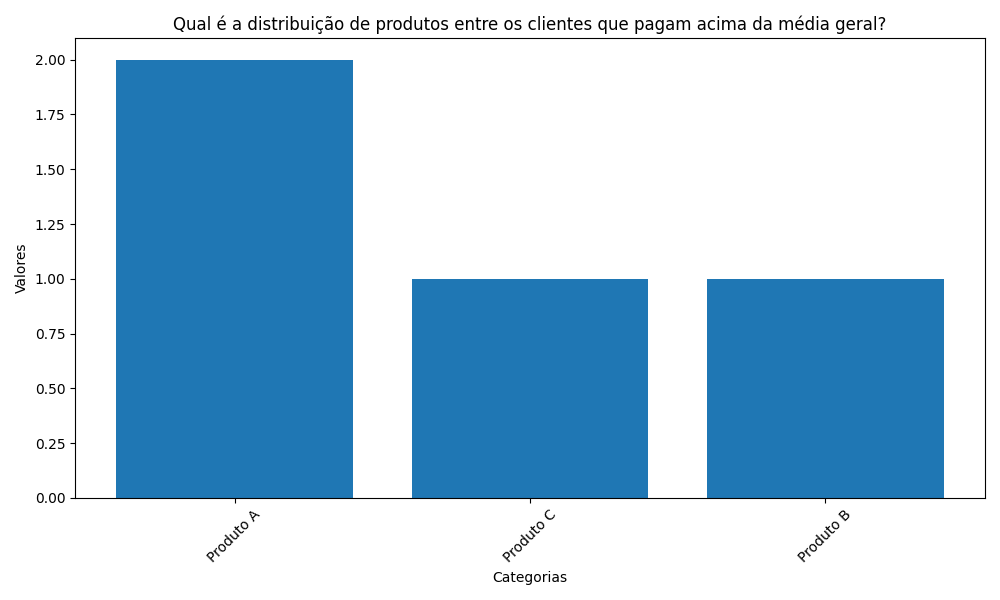

In [14]:
pergunta = "Qual é a distribuição de produtos entre os clientes que pagam acima da média geral?"
process_question(pergunta)

Consulta SQL Gerada:
 SELECT produto, COUNT(*) AS quantidade
FROM clientes
WHERE plano = 'anual'
GROUP BY produto
ORDER BY quantidade DESC
LIMIT 1;

Resultados da Consulta:
['Produto A', 2]

Interpretação:
O resultado da consulta indica que o produto mais popular entre os clientes que possuem um plano anual é o "Produto A", com um total de 2 compras. 

Como a resposta é um único valor, não é necessário sugerir um gráfico. Se você tiver mais dados ou quiser comparar a popularidade de outros produtos, sinta-se à vontade para realizar uma nova consulta!



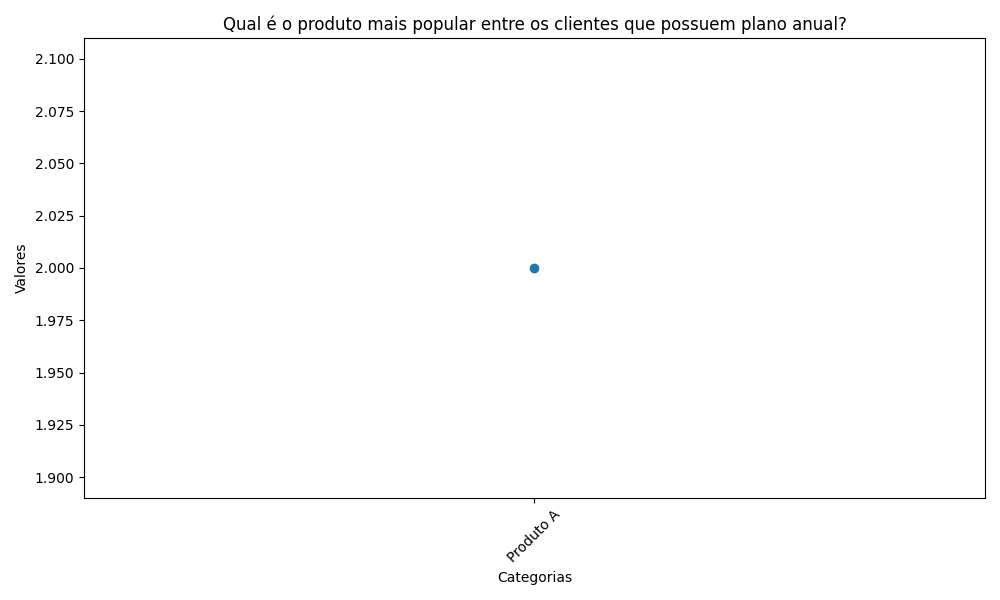

In [15]:
pergunta = "Qual é o produto mais popular entre os clientes que possuem plano anual?"
process_question(pergunta)

Consulta SQL Gerada:
 SELECT produto, COUNT(*) AS quantidade_vendida
FROM clientes
GROUP BY produto;

Resultados da Consulta:
['Produto A', 3]
['Produto C', 2]
['Produto B', 3]

Interpretação:
Os resultados da consulta mostram a quantidade de produtos vendidos, agrupados por tipo de produto. Os dados indicam que o "Produto A" e o "Produto B" foram os mais vendidos, com 3 unidades cada, enquanto o "Produto C" teve 2 unidades vendidas.

Portanto, a resposta à pergunta original é que os produtos mais vendidos foram o "Produto A" e o "Produto B", ambos com 3 vendas, seguidos pelo "Produto C" com 2 vendas.

Para visualizar esses dados, um gráfico de pizza seria apropriado, pois ele pode mostrar a proporção de cada produto em relação ao total de vendas, permitindo uma comparação visual clara entre os produtos.



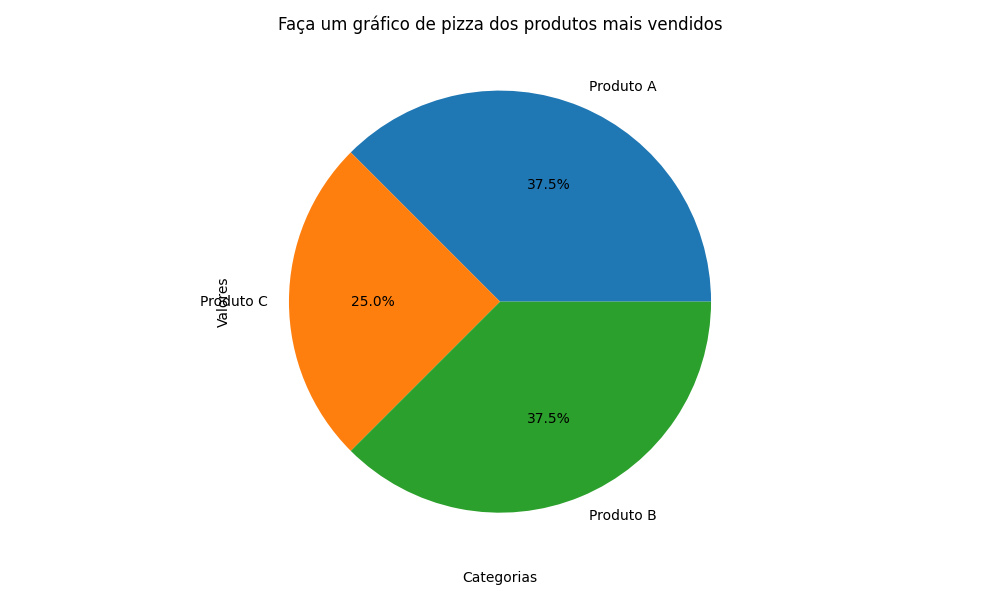

In [16]:
pergunta = "Faça um gráfico de pizza dos produtos mais vendidos"
process_question(pergunta)


# Explicação Detalhada dos Nós e Arestas no LangGraph

Neste documento, forneceremos uma explicação detalhada de cada nó e aresta criados no **LangGraph**, bem como a importância de cada componente. Além disso, discutiremos o que essa estrutura permite em termos de funcionalidade e vantagens no desenvolvimento de pipelines de processamento de linguagem natural e dados.

## Introdução ao LangGraph

**LangGraph** é uma biblioteca que permite a construção de fluxos de trabalho (workflows) baseados em grafos de estado. Cada nó no grafo representa uma função ou tarefa específica, e as arestas definem como o estado é transferido entre os nós. Isso permite criar pipelines modulares, flexíveis e fáceis de manter, especialmente ao trabalhar com modelos de linguagem e processamento de dados.

Ao utilizar o LangGraph, podemos definir claramente o fluxo de dados e decisões, facilitando a depuração, extensão e compreensão do sistema. Além disso, podemos incorporar lógica condicional e loops controlados, evitando problemas como recursões infinitas.

## Estrutura Geral do Grafo

O grafo construído é composto pelos seguintes nós:

1. **search_engineer_node**
2. **sql_writer_node**
3. **qa_engineer_node**
4. **chief_dba_node**
5. **execute_query_node**
6. **interpret_results_node**
7. **plot_results_node**

As arestas conectam esses nós de maneira a definir o fluxo de execução do pipeline.

## Descrição Detalhada dos Nós

### 1. search_engineer_node

**Função:**

- Recupera o esquema do banco de dados e configura o estado inicial.
- Define os campos `table_schemas` e `database` no estado.

**Importância:**

- Inicializa o estado com informações essenciais para os próximos passos.
- Garante que os nós subsequentes tenham acesso ao esquema do banco de dados necessário para gerar e validar consultas SQL.

### 2. sql_writer_node

**Função:**

- Gera a consulta SQL com base na pergunta do usuário.
- Usa o modelo de linguagem para transformar a pergunta em uma consulta SQL válida.
- Incrementa o contador de revisões (`revision`).

**Importância:**

- Traduz a linguagem natural em uma consulta SQL que pode ser executada no banco de dados.
- Essencial para automatizar a extração de informações solicitadas pelo usuário.

### 3. qa_engineer_node

**Função:**

- Verifica se a consulta SQL gerada responde corretamente à pergunta do usuário.
- Determina se a consulta é "ACEITA" ou "REJEITADA".

**Importância:**

- Garante a qualidade e a precisão da consulta SQL antes de executá-la.
- Evita a execução de consultas incorretas ou ineficientes no banco de dados.

### 4. chief_dba_node

**Função:**

- Fornece feedback detalhado para melhorar a consulta SQL rejeitada.
- Adiciona o feedback à lista `reflect` no estado.

**Importância:**

- Permite iterar e refinar a consulta SQL com base em recomendações especializadas.
- Melhora a eficiência e precisão das consultas geradas.

### 5. execute_query_node

**Função:**

- Executa a consulta SQL no banco de dados especificado.
- Armazena os resultados da consulta no estado.

**Importância:**

- Transforma a consulta SQL em dados concretos que podem ser analisados.
- Passo essencial para obter as informações solicitadas pelo usuário.

### 6. interpret_results_node

**Função:**

- Interpreta os resultados da consulta em linguagem natural.
- Sugere se um gráfico seria útil para representar os dados.
- Define o campo `interpretation` no estado.
- Determina se um gráfico é necessário, definindo `plot_needed`.

**Importância:**

- Transforma dados brutos em insights compreensíveis pelo usuário.
- Melhora a experiência do usuário ao fornecer explicações claras e sugestões de visualização.

### 7. plot_results_node

**Função:**

- Gera um gráfico com base nos resultados da consulta, se necessário.
- Converte o gráfico em HTML para exibição.
- Define o campo `plot_html` no estado.

**Importância:**

- Fornece uma visualização gráfica dos dados, facilitando a compreensão de tendências e padrões.
- Enriquece a resposta ao usuário com elementos visuais.

## Descrição das Arestas

As arestas no grafo definem como o estado é transferido entre os nós e determinam o fluxo de execução do pipeline.

### Fluxo Principal

1. **START -> search_engineer_node**

   - Início do grafo.
   - O fluxo começa com a configuração do estado inicial.

2. **search_engineer_node -> sql_writer_node**

   - Passa o estado inicializado para o nó que irá gerar a consulta SQL.

3. **sql_writer_node -> qa_engineer_node**

   - Transfere a consulta SQL gerada para validação.

### Aresta Condicional do qa_engineer_node

- **qa_engineer_node -> execute_query_node** (se a consulta for aceita ou o número máximo de revisões for alcançado)
- **qa_engineer_node -> chief_dba_node** (se a consulta for rejeitada e o número máximo de revisões não foi alcançado)

**Importância:**

- Controla o fluxo de decisão, permitindo revisões limitadas para melhorar a consulta.
- Evita loops infinitos ao estabelecer um número máximo de revisões.

### Fluxo Após a Validação

1. **chief_dba_node -> sql_writer_node**

   - Fornece feedback para o nó que gera a consulta, permitindo refinamento.

2. **execute_query_node -> interpret_results_node**

   - Transfere os resultados da consulta para interpretação.

3. **interpret_results_node -> plot_results_node**

   - Passa a interpretação para o nó que decide sobre a plotagem.

4. **plot_results_node -> END**

   - Finaliza o fluxo após a geração do gráfico ou não.

## Importância da Estrutura do Grafo

### Modularidade

- Cada nó representa uma função específica, permitindo isolamento e reutilização de componentes.
- Facilita a manutenção e a expansão do sistema.

### Controle de Fluxo

- As arestas definem claramente o caminho que o estado segue.
- A lógica condicional permite decisões dinâmicas com base no estado atual.

### Flexibilidade

- Podemos adicionar, remover ou modificar nós sem afetar drasticamente o restante do sistema.
- Possibilidade de incorporar novas funcionalidades, como diferentes tipos de visualizações.

### Transparência

- O fluxo de dados é transparente, facilitando o rastreamento e depuração.
- O uso de um grafo visual pode ajudar na compreensão do pipeline.

### Prevenção de Erros

- O controle sobre o número de revisões evita loops infinitos.
- A validação da consulta SQL antes da execução protege contra consultas malformadas ou potencialmente perigosas.

## O que Isso Permite?

- **Automatização Completa:** Permite automatizar o processo desde a pergunta do usuário até a apresentação dos resultados, incluindo visualizações gráficas.

- **Interatividade:** O sistema pode ser integrado em interfaces onde o usuário faz perguntas em linguagem natural e recebe respostas detalhadas.

- **Escalabilidade:** A estrutura modular facilita a adição de novas funcionalidades, como suporte a diferentes bancos de dados ou tipos de visualizações.

- **Personalização:** Podemos ajustar cada nó para atender a requisitos específicos, como políticas de segurança ou formatos de saída personalizados.

- **Manutenção Simplificada:** A separação de responsabilidades em nós distintos facilita a identificação e correção de problemas.

## Uso do Conhecimento sobre LangGraph

Ao longo de nossa interação, discutimos como o LangGraph facilita a criação de pipelines complexos de forma organizada. Aplicamos esses conceitos no desenvolvimento do script, aproveitando:

- **TypedDict para o Estado:** Definimos claramente os campos disponíveis no estado, garantindo consistência e autocompletação em IDEs.

- **Uso de Decoradores e Anotações:** Para adicionar funcionalidades, como acumulação de feedbacks com `Annotated[List[str], add]`.

- **Checkpointers:** Utilizamos o `MemorySaver` para gerenciar o estado e permitir retomadas ou análises do fluxo.

- **Streams:** O método `graph.stream` nos permite iterar sobre o fluxo de execução, útil para monitoramento e depuração.

- **Mensagens de Sistema e Usuário:** Estruturamos as interações com o modelo de linguagem usando `SystemMessage` e `HumanMessage`, seguindo boas práticas.

## Conclusão

A construção deste grafo com o LangGraph nos permitiu criar um pipeline robusto, flexível e eficiente para processar perguntas em linguagem natural, gerar consultas SQL, executar e interpretar resultados, e decidir sobre a necessidade de visualizações gráficas. A abordagem modular facilita a manutenção, a escalabilidade e a adaptação a novos requisitos.

Ao entender cada componente em detalhe, podemos apreciar como cada parte contribui para o todo, proporcionando uma experiência de usuário aprimorada e um sistema sólido para processamento de linguagem e dados.
